In [108]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from datetime import timedelta
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [158]:
class dataset():
    def __init__(self, DataToExplain, ExplainingData1, ExplainingData2 ):
        self.DataToExplain = DataToExplain
        self.ExplainingData1 = ExplainingData1
        self.ExplainingData2 = ExplainingData2
        
        
    
    def preprocess_DataToExplain(self):
        
        self.DataToExplain.iloc[:,3] = self.DataToExplain.iloc[:,3].astype('datetime64[ns]')
#        data1.tail()
        self.DataToExplain.columns = ['n1','n2', 'OurPrice', 'Date']
        VA = pd.DataFrame(self.DataToExplain,columns= ['Date','OurPrice'])
        VAdate = VA.iloc[:,0]
        indices = list(VAdate[( VAdate < "2021-03-31") &  (VAdate > "2019-03-30")].index)
        VA = VA.iloc[indices,:]
        VA.reset_index(drop=True, inplace=True)
        return (VA)
    
    def preprocess_ExplainingData1(self):

        rng0 = range(0, len(data2.columns), 2)
        for i in rng0:
            self.ExplainingData1.iloc[:,i] = pd.to_datetime(self.ExplainingData1.iloc[:,i], format='%d/%m/%Y').dt.date
            self.ExplainingData1.iloc[:,i] = self.ExplainingData1.iloc[:,i].astype('datetime64[ns]')
        
        rng1 = range(1, len(self.ExplainingData1.columns)+1, 2)
        nb_col = len(self.ExplainingData1.columns)//2
        columns= list(self.ExplainingData1.columns[rng1])
    
        data2years= list()
    
        datatime = self.ExplainingData1.iloc[:,0]
        datelist = list(datatime[( datatime < "2021-03-31") &  (datatime > "2019-03-30")])
    
        data2years.append(datelist)
    
        columns_new= ["Date"]
        for i in range(nb_col):
            data = self.ExplainingData1.iloc[:,2*i]
            indices = list(data[( data < "2021-03-31") &  (data > "2019-03-30")].index)
            L = list(self.ExplainingData1.iloc[indices,2*i+1])
            if len(L) == len(datelist):
                data2years.append(L)
                columns_new.append(columns[i])
            
        data2years = np.array(data2years)
#        data2years.shape
        data2years = pd.DataFrame(data2years)
        data2years = data2years.transpose()
        data2years.columns = columns_new
        
        return(data2years)
    
    def preprocess_ExplainingData2(self):
        self.ExplainingData2.iloc[:,2] = pd.to_datetime(self.ExplainingData2.iloc[:,2], format='%d/%m/%Y').dt.date
        self.ExplainingData2.iloc[:,2] = self.ExplainingData2.iloc[:,2].astype('datetime64[ns]')
        
        self.ExplainingData2.columns = ['num', 'Explaining_Price' ,'Date']
        new_data = pd.DataFrame(self.ExplainingData2,columns= ['Date','Explaining_Price'])

        indices = list(new_data['Date'][(new_data['Date']< "2021-03-31") &  (new_data['Date'] > "2019-03-30")].index)
        new_data = new_data.iloc[indices,:]
        new_data.reset_index(drop=True, inplace=True)
        return(new_data)


    def export_ExplainingData1(self,path):
        self.preprocess_ExplainingData1().to_csv (path, sep= ';', index = False, header=True)
    
    def export_ExplainingData1(self,path):
        self.preprocess_ExplainingData2().to_csv (path, sep= ';', index = False, header=True)
    

    def DataTwoLastYears(self):
        DataToExplain= self.preprocess_DataToExplain()
        ExplainingData1 = self.preprocess_ExplainingData1()
        ExplainingData2 = self.preprocess_ExplainingData2()
        ExplainingData = ExplainingData1.join(ExplainingData2.set_index('Date'), on='Date')
        TwoYearsdata = ExplainingData.join( DataToExplain.set_index('Date'), on='Date')
        TwoYearsdata = TwoYearsdata.fillna(TwoYearsdata.mean())
        return(TwoYearsdata)

    def AnalyseAcp(self, data, n_comp = 3, name='OurPrice'):
        data_pca = data.iloc[:,1:-1]
        features = data.iloc[:,1:].columns

        # Do the PCA.
        n_components=3
        pca = PCA(n_components=n_components)
        reduced = pca.fit_transform(data_pca)

        # Append the principle components for each entry to the dataframe
        for i in range(0, n_components):
            data_pca['PC' + str(i + 1)] = reduced[:, i]
        display(data_pca.head())

        # Do a scree plot
        ind = np.arange(0, n_components)
        (fig, ax) = plt.subplots(figsize=(8, 6))
        sns.pointplot(x=ind, y=pca.explained_variance_ratio_)
        ax.set_title('Scree plot')
        ax.set_xticks(ind)
        ax.set_xticklabels(ind)
        ax.set_xlabel('Component Number')
        ax.set_ylabel('Explained Variance')
        plt.show()

        # Show the points in terms of the first two PCs
        g = sns.lmplot('PC1',
                       'PC2',data=data_pca,
                       fit_reg=False,
                       scatter=True,
                       size=7)

        plt.show()

        # Plot a variable factor map for the first two dimensions.
        (fig, ax) = plt.subplots(figsize=(8, 8))
        for i in range(0, pca.components_.shape[1]):
            if (data_pca.columns.values[i] == name):
                ax.arrow(0,
                        0,  # Start the arrow at the origin
                        pca.components_[0, i],  #0 for PC1
                        pca.components_[1, i],  #1 for PC2
                        head_width=0.01,
                        head_length=0.01,
                        color ='r')
            else: 
                ax.arrow(0,
                        0,  # Start the arrow at the origin
                        pca.components_[0, i],  #0 for PC1
                        pca.components_[1, i],  #1 for PC2
                        head_width=0.01,
                        head_length=0.01)
                        
        #    plt.text(pca.components_[0, i] + 0.05,
        #             pca.components_[1, i] + 0.05,
        #             data_pca.columns.values[i])


        an = np.linspace(0, 2 * np.pi, 100)
        plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
        plt.axis('equal')
        ax.set_title('Variable factor map')
        plt.show()

        return reduced

    

In [110]:
data1 = pd.read_csv("VariableAexpliquer.csv", header=None, sep=',')
data2 = pd.read_csv("VariableExplicative1.csv", header=0 , sep=';')
data3 = pd.read_csv("VariableExplicative2.csv", header=None, sep=';')

data1.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,2,4,6,8,10,12,14,16,18,20,22,24,28,30,32,34,36,38,40,42,44,46,48,50,52,54,56,58,60,62,64,66,68,70,72,74,76,78,80,82,84,86,88,90,92,94,96,98,100,102,104,106,108,110,112,114,116,118,120,122,124,126,128,130,132,134,136,138,140,142,144,146,148,150,152,154,156,158,166,168,170,172,174,176,178,180,182,184,186,188,190,192,194,196,198,200,202,204,206,208,210,212,214,216,218,220,222,224,226,228,230,232,234,236,238,240,242,244,246,248,250,252,254,256,258,260,262,264,266,268,270,272,274,276,278,280,282,284,286,288,290,292,294,296,298,300,302,304) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,0,1,2,3
0,8920837,47762,100.00,2006-06-21
1,8920838,47762,99.84,2006-06-22
2,8920839,47762,100.16,2006-06-26
3,8920840,47762,98.70,2006-06-27
4,8920841,47762,99.42,2006-06-28


In [111]:
data2.head()

,date_EMU Equity Mid-Cap,prices_EMU Equity Mid-Cap,date_EMU Equity Mix-Cap,prices_EMU Equity Mix-Cap,date_EMU Equity Small-Cap,prices_EMU Equity Small-Cap,date_EMU Equity Small-Cap Growth,prices_EMU Equity Small-Cap Growth,date_EMU Equity Large-Mid-Cap Growth,prices_EMU Equity Large-Mid-Cap Growth,date_EMU Equity Large-Mid-Cap Quality,prices_EMU Equity Large-Mid-Cap Quality,date_EMU Equity Large-Mid-Cap Multi Factors,prices_EMU Equity Large-Mid-Cap Multi Factors,date_EMU Equity Large-Mid-Cap Value,prices_EMU Equity Large-Mid-Cap Value,date_EMU Equity Large-Mid-Cap Low volatility,prices_EMU Equity Large-Mid-Cap Low volatility,date_EMU Equity Large-Mid-Cap Income,prices_EMU Equity Large-Mid-Cap Income,date_Global Equity Large-Cap,prices_Global Equity Large-Cap,date_Global Equity Mix-Cap,prices_Global Equity Mix-Cap,date_Global Equity Small-Mid-Cap,prices_Global Equity Small-Mid-Cap,date_Global Equity Large-Mid-Cap Growth,prices_Global Equity Large-Mid-Cap Growth,date_Global Equity Large-Mid-Cap Income,prices_Global Equity Large-Mid-Cap Income,date_Global Equity Large-Mid-Cap Low volatility,prices_Global Equity Large-Mid-Cap Low volatility,date_Global Equity Large-Mid-Cap Momentum,prices_Global Equity Large-Mid-Cap Momentum,date_Global Equity Large-Mid-Cap Multi Factors,prices_Global Equity Large-Mid-Cap Multi Factors,date_Global Equity Large-Mid-Cap Value,prices_Global Equity Large-Mid-Cap Value,date_Global Equity Large-Mid-Cap Quality,prices_Global Equity Large-Mid-Cap Quality,...,date_Information Technology Equity,prices_Information Technology Equity,date_Financials Equity,prices_Financials Equity,date_New Energy Equity,prices_New Energy Equity,date_Basic Resources Equity,prices_Basic Resources Equity,date_Water Equity,prices_Water Equity,date_Biotech Equity,prices_Biotech Equity,date_Private Equity,prices_Private Equity,date_Agriculture Equity,prices_Agriculture Equity,date_Communication Equity,prices_Communication Equity,date_Utilities Equity,prices_Utilities Equity,date_Metals & Mining Equity,prices_Metals & Mining Equity,date_ASEAN Equity Mix-Cap,prices_ASEAN Equity Mix-Cap,date_Asia ExJapan Equity Mix-Cap,prices_Asia ExJapan Equity Mix-Cap,date_Asia ExJapan Equity Mix-Cap Growth,prices_Asia ExJapan Equity Mix-Cap Growth,date_Asia ExJapan Equity Small-Mid-cap,prices_Asia ExJapan Equity Small-Mid-cap,date_Asia Pacific ExJapan Equity Mix-Cap,prices_Asia Pacific ExJapan Equity Mix-Cap,date_Asia Pacific ExJapan Equity Mix-Cap Growth,prices_Asia Pacific ExJapan Equity Mix-Cap Growth,date_Asia Pacific ExJapan Equity Mix-Cap Value,prices_Asia Pacific ExJapan Equity Mix-Cap Value,date_Asia ExJapan Equity Mix-Cap Low Vol & Income,prices_Asia ExJapan Equity Mix-Cap Low Vol & Income,date_Asia Pacific ExJapan Equity Mix-Cap Low Vol & Income,prices_Asia Pacific ExJapan Equity Mix-Cap Low Vol & Income
0,18/10/1999,100.000000,11/06/1996,100.000000,13/04/1995,100.000000,24/03/1994,100.000000,01/06/1992,100.000000,28/07/1997,100.000000,09/11/2006,100.000000,29/12/1995,100.000000,28/05/1998,100.000000,24/11/1997,100.000000,22/07/1985,100.000000,02/01/1992,100.000000,12/11/1993,100.000000,31/12/1969,100.000000,30/04/1986,100.000000,27/04/1998,100.000000,18/02/1998,100.000000,01/02/2002,100.000000,04/01/1982,100.000000,16/03/1998,100.000000,...,31/12/1991,100.000000,31/10/1986,100.000000,11/06/1992,100.000000,23/03/1990,100.000000,19/01/2000,100.000000,15/10/1996,100.000000,01/01/2002,100.0,20/11/2006,100.000000,25/06/1999,100.000000,07/07/2000,100.000000,10/06/1991,100.000000,25/09/2006,100.000000,15/10/1984,100.000000,01/11/1991,100.000000,01/02/1999,100.000000,30/11/1990,100.000000,29/03/1985,100.000000,16/08/1996,100.000000,15/02/2000,100.000000,01/02/1991,100.000000
1,19/10/1999,100.147586,12/06/1996,99.989838,14/04/1995,100.392491,25/03/1994,99.900894,02/06/1992,100.049205,29/07/1997,99.262456,10/11/2006,99.961453,01/01/1996,100.000000,29/05/1998,99.996602,25/11/1997,99.253338,23/07/1985,104.160752,03/01/1992,98.527237,15/11/1993,100.50

In [11]:
data3.head()

,0,1,2
0,25,0.002778,01/01/1960
1,25,0.002778,02/01/1960
2,25,0.002778,03/01/1960
3,25,0.002778,04/01/1960
4,25,0.002778,05/01/1960


In [160]:
d = dataset(data1,data2,data3)
d.DataToExplain

,n1,n2,OurPrice,Date
0,8920837,47762,100.000000,2006-06-21
1,8920838,47762,99.840000,2006-06-22
2,8920839,47762,100.160000,2006-06-26
3,8920840,47762,98.700000,2006-06-27
4,8920841,47762,99.420000,2006-06-28
...,...,...,...,...
3593,37413153,47762,272.145100,2021-03-22
3594,37413154,47762,268.853627,2021-03-23
3595,37413155,47762,265.662235,2021-03-24
3596,37413156,47762,267.170756,2021-03-25


In [122]:
DataToExplain= d.preprocess_DataToExplain()
DataToExplain

,Date,OurPrice
0,2019-04-01,211.770000
1,2019-04-02,212.000000
2,2019-04-03,212.990000
3,2019-04-04,212.920000
4,2019-04-05,213.680000
...,...,...
473,2021-03-22,272.145100
474,2021-03-23,268.853627
475,2021-03-24,265.662235
476,2021-03-25,267.170756


In [123]:
ExplainingData2 = d.preprocess_ExplainingData2()
ExplainingData2

,Date,Explaining_Price
0,2019-03-31,0.009028
1,2019-04-01,0.009012
2,2019-04-02,0.008979
3,2019-04-03,0.008973
4,2019-04-05,0.008955
...,...,...
668,2021-02-02,0.009524
669,2021-02-03,0.009518
670,2021-02-04,0.009503
671,2021-02-05,0.009456


In [124]:
 ExplainingData1 = d.preprocess_ExplainingData1()
 ExplainingData1

,Date,prices_EMU Equity Mid-Cap,prices_EMU Equity Mix-Cap,prices_EMU Equity Small-Cap,prices_EMU Equity Small-Cap Growth,prices_EMU Equity Large-Mid-Cap Growth,prices_EMU Equity Large-Mid-Cap Quality,prices_EMU Equity Large-Mid-Cap Multi Factors,prices_EMU Equity Large-Mid-Cap Value,prices_EMU Equity Large-Mid-Cap Low volatility,prices_EMU Equity Large-Mid-Cap Income,prices_Global Equity Large-Cap,prices_Global Equity Mix-Cap,prices_Global Equity Small-Mid-Cap,prices_Global Equity Large-Mid-Cap Growth,prices_Global Equity Large-Mid-Cap Income,prices_Global Equity Large-Mid-Cap Low volatility,prices_Global Equity Large-Mid-Cap Momentum,prices_Global Equity Large-Mid-Cap Multi Factors,prices_Global Equity Large-Mid-Cap Value,prices_Global Equity Large-Mid-Cap Quality,prices_Europe Equity Large-Cap,prices_Europe Equity Large-Cap Low volatility,prices_Europe Equity Mid-Cap,prices_Europe Equity Small-Cap,prices_Europe Equity Small-Mid-Cap,prices_Europe ExCH Equity Large-Cap,prices_Europe Equity Large-Mid-Cap Growth,prices_Europe Equity Large-Mid-Cap Income,prices_Europe Equity Large-Mid-Cap Value,prices_France Equity Large-Cap,prices_France Equity Small-Cap,prices_France Equity Small-Mid-Cap,prices_France Equity Small-Mid-Cap Growth,prices_France Equity Small-Cap Growth,prices_France Equity Large-Cap Growth,prices_EMU Equity Large-Mid-Cap,prices_US Equity Large-Cap,prices_US Equity Large-Mid-Cap Growth,prices_US Equity Small-Cap Value,...,prices_Global Blend Bonds,prices_Global Inflation Bonds,prices_USD Corporate Bonds,prices_USD High Yield Bonds,prices_USD Diversified Bonds,prices_USD Diversified Short Term Bonds,prices_USD Flexible Bonds,prices_USD Sovereign Bonds,prices_USD Inflation Bonds,prices_Asia High Yield Bonds,prices_Asia Bonds,prices_Emerging Fixed Maturity Bonds,prices_Emerging Market Bonds,prices_Emerging Market Corporate Bonds,prices_Consumer Staples Equity,prices_Infrastructure Equity,prices_Materials Equity,prices_Energy Equity,prices_Health Care Equity,prices_Ecology Equity,prices_Information Technology Equity,prices_Financials Equity,prices_New Energy Equity,prices_Basic Resources Equity,prices_Water Equity,prices_Biotech Equity,prices_Private Equity,prices_Agriculture Equity,prices_Communication Equity,prices_Utilities Equity,prices_Metals & Mining Equity,prices_ASEAN Equity Mix-Cap,prices_Asia ExJapan Equity Mix-Cap,prices_Asia ExJapan Equity Mix-Cap Growth,prices_Asia ExJapan Equity Small-Mid-cap,prices_Asia Pacific ExJapan Equity Mix-Cap,prices_Asia Pacific ExJapan Equity Mix-Cap Growth,prices_Asia Pacific ExJapan Equity Mix-Cap Value,prices_Asia ExJapan Equity Mix-Cap Low Vol & Income,prices_Asia Pacific ExJapan Equity Mix-Cap Low Vol & Income
0,2019-04-01,440.74,733.14,445.679,1405.45,645.043,301.415,156.82,602.974,401.333,389.765,1836.6,978.039,1627.77,13694,1442.57,437.707,467.26,318.542,1336.17,330.633,1560.15,382.889,984.022,1640.66,1122.23,232.814,1184.46,1028.67,904.469,824.888,226.108,836.073,1153.51,520.941,262.551,157.35,7816.89,9024.35,350.252,...,915.192,280.97,274.69,295.959,1332.36,211.367,323.367,361.224,101.681,192.98,483.155,115.359,395.25,222.793,1031.24,722.493,433.341,627.409,1584.58,1032.05,2961.55,2137.46,544.656,537.942,601.752,2623.97,344.888,213.389,238.949,398.741,1228.42,267.961,4910.45,1374.17,1647.68,2126.53,8295.05,597.139,476.885,1413.66
1,2019-04-02,442.17,736.059,447.68,1411.45,647.155,302.54,157.415,606.061,402.797,391.784,1838.65,979.179,1628.36,13717.2,1444.52,437.009,467.107,318.997,1338.05,330.215,1566.63,383.944,989.019,1647.95,1126.69,233.374,1189,1033.42,909.138,827.961,226.901,840.146,1159.37,523.247,263.388,157.74,7824.51,9047.99,349.567,...,912.854,280.529,274.571,296.016,1331.81,211.353,323.37,360.779,101.755,192.757,482.936,115.054,394.996,222.805,1030.62,722.212,435.207,626.938,1582.36,1033.38,2970.44,2144.1,546.604,537.917,601.704,2641,345.534,213.421,238.911,398.86,1217.64,268.984,4923.78,1377.97,1652.14,2129.19,8293.98,600.681,477.459,1415.4
2,2019-04-03,446

In [161]:
# d1.set_index('Date').join(d2.set_index('Date'))
# ExplainingData = ExplainingData1.join(ExplainingData2.set_index('Date'), on='Date')
# TwoYearsdata = ExplainingData.join( DataToExplain.set_index('Date'), on='Date')
# TwoYearsdata = TwoYearsdata.fillna(TwoYearsdata.mean())

TwoYearsdata = d.DataTwoLastYears()
TwoYearsdata

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.


,Date,prices_EMU Equity Mid-Cap,prices_EMU Equity Mix-Cap,prices_EMU Equity Small-Cap,prices_EMU Equity Small-Cap Growth,prices_EMU Equity Large-Mid-Cap Growth,prices_EMU Equity Large-Mid-Cap Quality,prices_EMU Equity Large-Mid-Cap Multi Factors,prices_EMU Equity Large-Mid-Cap Value,prices_EMU Equity Large-Mid-Cap Low volatility,prices_EMU Equity Large-Mid-Cap Income,prices_Global Equity Large-Cap,prices_Global Equity Mix-Cap,prices_Global Equity Small-Mid-Cap,prices_Global Equity Large-Mid-Cap Growth,prices_Global Equity Large-Mid-Cap Income,prices_Global Equity Large-Mid-Cap Low volatility,prices_Global Equity Large-Mid-Cap Momentum,prices_Global Equity Large-Mid-Cap Multi Factors,prices_Global Equity Large-Mid-Cap Value,prices_Global Equity Large-Mid-Cap Quality,prices_Europe Equity Large-Cap,prices_Europe Equity Large-Cap Low volatility,prices_Europe Equity Mid-Cap,prices_Europe Equity Small-Cap,prices_Europe Equity Small-Mid-Cap,prices_Europe ExCH Equity Large-Cap,prices_Europe Equity Large-Mid-Cap Growth,prices_Europe Equity Large-Mid-Cap Income,prices_Europe Equity Large-Mid-Cap Value,prices_France Equity Large-Cap,prices_France Equity Small-Cap,prices_France Equity Small-Mid-Cap,prices_France Equity Small-Mid-Cap Growth,prices_France Equity Small-Cap Growth,prices_France Equity Large-Cap Growth,prices_EMU Equity Large-Mid-Cap,prices_US Equity Large-Cap,prices_US Equity Large-Mid-Cap Growth,prices_US Equity Small-Cap Value,...,prices_USD Corporate Bonds,prices_USD High Yield Bonds,prices_USD Diversified Bonds,prices_USD Diversified Short Term Bonds,prices_USD Flexible Bonds,prices_USD Sovereign Bonds,prices_USD Inflation Bonds,prices_Asia High Yield Bonds,prices_Asia Bonds,prices_Emerging Fixed Maturity Bonds,prices_Emerging Market Bonds,prices_Emerging Market Corporate Bonds,prices_Consumer Staples Equity,prices_Infrastructure Equity,prices_Materials Equity,prices_Energy Equity,prices_Health Care Equity,prices_Ecology Equity,prices_Information Technology Equity,prices_Financials Equity,prices_New Energy Equity,prices_Basic Resources Equity,prices_Water Equity,prices_Biotech Equity,prices_Private Equity,prices_Agriculture Equity,prices_Communication Equity,prices_Utilities Equity,prices_Metals & Mining Equity,prices_ASEAN Equity Mix-Cap,prices_Asia ExJapan Equity Mix-Cap,prices_Asia ExJapan Equity Mix-Cap Growth,prices_Asia ExJapan Equity Small-Mid-cap,prices_Asia Pacific ExJapan Equity Mix-Cap,prices_Asia Pacific ExJapan Equity Mix-Cap Growth,prices_Asia Pacific ExJapan Equity Mix-Cap Value,prices_Asia ExJapan Equity Mix-Cap Low Vol & Income,prices_Asia Pacific ExJapan Equity Mix-Cap Low Vol & Income,Explaining_Price,OurPrice
0,2019-04-01,440.739733,733.139598,445.679417,1405.448459,645.043486,301.414637,156.819734,602.973506,401.333227,389.764758,1836.601704,978.039240,1627.768902,13694.030441,1442.568699,437.707230,467.259895,318.542040,1336.169144,330.633244,1560.149076,382.889229,984.022221,1640.662506,1122.234248,232.813831,1184.459531,1028.669371,904.469073,824.888169,226.108499,836.072565,1153.508338,520.940502,262.550622,157.349808,7816.891087,9024.354713,350.251566,...,274.689604,295.959334,1332.361770,211.366581,323.366632,361.223953,101.680841,192.979719,483.155342,115.358632,395.250475,222.793360,1031.237826,722.492655,433.341438,627.408923,1584.584983,1032.054659,2961.552624,2137.460707,544.656408,537.942263,601.752311,2623.973835,344.887927,213.388757,238.949489,398.740734,1228.418086,267.961184,4910.446779,1374.166588,1647.682698,2126.527893,8295.054435,597.139314,476.885032,1413.660203,0.009012,211.770000
1,2019-04-02,442.169601,736.059297,447.679896,1411.451745,647.155107,302.540053,157.415436,606.060568,402.797027,391.783741,1838.652449,979.178943,1628.357696,13717.215343,1444.515579,437.008668,467.107102,318.996859,1338.047499,330.214863,1566.633589,383.944367,989.018939,1647.952070,1126.690049,233.374098,1188.997094,1033.422721,909.137912,827.960507,226.901350,840.146436,1159.369859,523.246724,263.3

In [ ]:
d.export_ExplainingData1('C:\\Users\\Younes\\Desktop\\data2years.csv')

In [87]:
TwoYearsdata.to_csv ('data2years.csv', sep= ';', index = False, header=True)


In [ ]:

ExplainingData1.to_csv ('data2.csv', sep= ';', index = False, header=True)

,prices_EMU Equity Mid-Cap,prices_EMU Equity Mix-Cap,prices_EMU Equity Small-Cap,prices_EMU Equity Small-Cap Growth,prices_EMU Equity Large-Mid-Cap Growth,prices_EMU Equity Large-Mid-Cap Quality,prices_EMU Equity Large-Mid-Cap Multi Factors,prices_EMU Equity Large-Mid-Cap Value,prices_EMU Equity Large-Mid-Cap Low volatility,prices_EMU Equity Large-Mid-Cap Income,prices_Global Equity Large-Cap,prices_Global Equity Mix-Cap,prices_Global Equity Small-Mid-Cap,prices_Global Equity Large-Mid-Cap Growth,prices_Global Equity Large-Mid-Cap Income,prices_Global Equity Large-Mid-Cap Low volatility,prices_Global Equity Large-Mid-Cap Momentum,prices_Global Equity Large-Mid-Cap Multi Factors,prices_Global Equity Large-Mid-Cap Value,prices_Global Equity Large-Mid-Cap Quality,prices_Europe Equity Large-Cap,prices_Europe Equity Large-Cap Low volatility,prices_Europe Equity Mid-Cap,prices_Europe Equity Small-Cap,prices_Europe Equity Small-Mid-Cap,prices_Europe ExCH Equity Large-Cap,prices_Europe Equity Large-Mid-Cap Growth,prices_Europe Equity Large-Mid-Cap Income,prices_Europe Equity Large-Mid-Cap Value,prices_France Equity Large-Cap,prices_France Equity Small-Cap,prices_France Equity Small-Mid-Cap,prices_France Equity Small-Mid-Cap Growth,prices_France Equity Small-Cap Growth,prices_France Equity Large-Cap Growth,prices_EMU Equity Large-Mid-Cap,prices_US Equity Large-Cap,prices_US Equity Large-Mid-Cap Growth,prices_US Equity Small-Cap Value,prices_US Equity Small-Cap,...,prices_USD Diversified Bonds,prices_USD Diversified Short Term Bonds,prices_USD Flexible Bonds,prices_USD Sovereign Bonds,prices_USD Inflation Bonds,prices_Asia High Yield Bonds,prices_Asia Bonds,prices_Emerging Fixed Maturity Bonds,prices_Emerging Market Bonds,prices_Emerging Market Corporate Bonds,prices_Consumer Staples Equity,prices_Infrastructure Equity,prices_Materials Equity,prices_Energy Equity,prices_Health Care Equity,prices_Ecology Equity,prices_Information Technology Equity,prices_Financials Equity,prices_New Energy Equity,prices_Basic Resources Equity,prices_Water Equity,prices_Biotech Equity,prices_Private Equity,prices_Agriculture Equity,prices_Communication Equity,prices_Utilities Equity,prices_Metals & Mining Equity,prices_ASEAN Equity Mix-Cap,prices_Asia ExJapan Equity Mix-Cap,prices_Asia ExJapan Equity Mix-Cap Growth,prices_Asia ExJapan Equity Small-Mid-cap,prices_Asia Pacific ExJapan Equity Mix-Cap,prices_Asia Pacific ExJapan Equity Mix-Cap Growth,prices_Asia Pacific ExJapan Equity Mix-Cap Value,prices_Asia ExJapan Equity Mix-Cap Low Vol & Income,prices_Asia Pacific ExJapan Equity Mix-Cap Low Vol & Income,Explaining_Price,PC1,PC2,PC3
0,440.739733,733.139598,445.679417,1405.448459,645.043486,301.414637,156.819734,602.973506,401.333227,389.764758,1836.601704,978.039240,1627.768902,13694.030441,1442.568699,437.707230,467.259895,318.542040,1336.169144,330.633244,1560.149076,382.889229,984.022221,1640.662506,1122.234248,232.813831,1184.459531,1028.669371,904.469073,824.888169,226.108499,836.072565,1153.508338,520.940502,262.550622,157.349808,7816.891087,9024.354713,350.251566,6633.469742,...,1332.361770,211.366581,323.366632,361.223953,101.680841,192.979719,483.155342,115.358632,395.250475,222.793360,1031.237826,722.492655,433.341438,627.408923,1584.584983,1032.054659,2961.552624,2137.460707,544.656408,537.942263,601.752311,2623.973835,344.887927,213.388757,238.949489,398.740734,1228.418086,267.961184,4910.446779,1374.166588,1647.682698,2126.527893,8295.054435,597.139314,476.885032,1413.660203,0.009012,1812.257244,-3143.789780,597.768698
1,442.169601,736.059297,447.679896,1411.451745,647.155107,302.540053,157.415436,606.060568,402.797027,391.783741,1838.652449,979.178943,1628.357696,13717.215343,1444.515579,437.008668,467.107102,318.996859,1338.047499,330.214863,1566.633589,383.944367,989.018939,1647.952070,1126.690049,233.374098,1188.997094,1033.422721,909.137912,827.960507,226.901350,840.146436,1159.369859,523.246724,263.388412,157.739812,7824.511415,9047.994

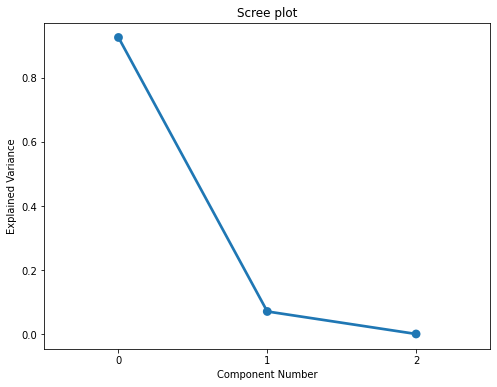

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


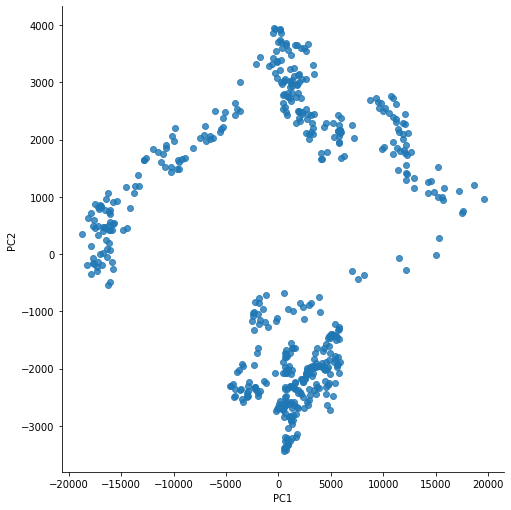

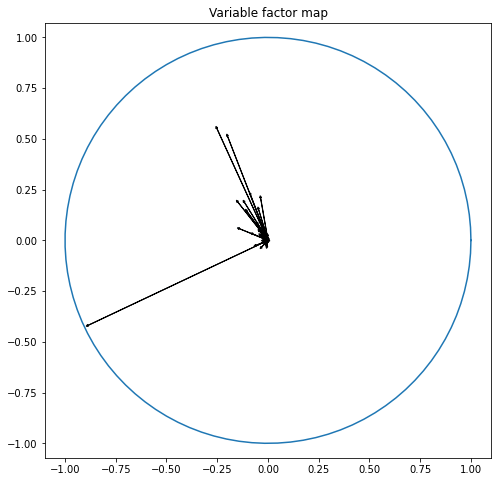

array([[  1812.25724385,  -3143.78977976,    597.76869758],
       [  1637.33610791,  -3187.15142378,    595.09177667],
       [  1256.27239251,  -3217.29621866,    613.27283436],
       ...,
       [-16759.42778122,     22.16030507,   -274.19900197],
       [-17251.06262051,    340.04643253,   -413.87771508],
       [-17886.43380895,    137.84045457,   -344.57802145]])

In [151]:
d.AnalyseAcp(TwoYearsdata,3,'OurPrice')

## Linear Regression

In [155]:
X = TwoYearsdata.iloc[:,1:].to_numpy()
print("X shape: ", X.shape)

y = TwoYearsdata.iloc[:,0].to_numpy()
print("y shape: ", y.shape)

X shape:  (522, 147)
y shape:  (522,)


In [162]:
split = 75

# Split the data into training/testing sets
X_train = X[:-split]
X_test = X[-split:]

# Split the targets into training/testing sets
y_train = y[:-split]
y_test = y[-split:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Coefficients: 
 [ 2.24107151e+13 -6.33413474e+13 -1.43363081e+13 -1.01686931e+13
  3.75450272e+13 -1.41016785e+12 -1.26444072e+14 -6.48156177e+13
  1.66693027e+13  1.12262487e+13 -3.62687557e+13 -1.02680654e+13
  3.51503074e+13 -6.54935675e+11  4.53580617e+12 -1.97276380e+13
  5.57129079e+12 -9.47337893e+13  1.38551460e+13 -3.91634474e+13
 -3.46291936e+12  5.17632286e+13  2.05306798e+13 -3.52180838e+12
 -1.59028812e+13  1.02294028e+14 -1.51292102e+13 -2.29930270e+13
  1.43100326e+13  1.02338541e+13  7.13044049e+13  2.29261109e+13
 -1.75203451e+13 -6.74878836e+12  5.25076468e+13  3.61338477e+13
  3.23096127e+12 -2.17651932e+11 -2.11193389e+13 -2.66236225e+12
 -1.18170886e+12  2.83088756e+13  7.36460011e+11  1.46137958e+11
  5.54378682e+13 -7.47147519e+11  4.14929486e+13  1.63205658e+12
 -1.08332851e+14 -7.90298572e+12  1.55906380e+13 -4.58591742e+12
  3.74996278e+13 -3.55006566e+12 -1.67301995e+11 -8.35657685e+13
  1.83325827e+13  1.06058585e+12  4.70231969e+12 -3.39940919e+13
  3.04598

UFuncTypeError: ignored

In [163]:
pred_all = X.dot(regr.coef_) + regr.intercept_

plt.figure(figsize=(10,7))
plt.plot(pred_all, label="predicted", color= "blue")
plt.plot(y, label="groundtruth", color="red")
plt.title("Linear regression model")
plt.legend()
plt.show()

ValueError: ignored